# Inference and Validation

Now that you have trained a network, you can use it for making predictions. This is typically called **inference**, a term borrowed from statistics. However, neural networks have a tendency to perform *too well* on the training data and aren't able to generalize to data that it hasn't seen before. This is called **overfitting** and it impairs inference performance. To test for overfitting while training, we measure the performance on data not in the training set called the **validation** set. We avoid overfitting through regularization such as dropout while monitoring the validation performance during training. In this notebook, this will be shown in PyTorch.

Let's start by loading the dataset through torchvision. This time we will be taking advantage of the test set which we can get by setting `train=False` here:

```python
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)
```

The test set contains images just like the training set. Typically you will see 10-20% of the original dataset held out for testing and validation with the rest being used for training.

In [11]:
import torch
from torchvision import datasets, transforms

In [12]:
# Define a transform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])

# Download and load the training data
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                 train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Download and load the test data
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True,
                                train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

Here let's create a model, using the solution from the instructor for part 4.

In [13]:
from torch import nn, optim
import torch.nn.functional as F

In [14]:
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

  def forward(self, x):
    # Make sure input tensor is flattened
    x = x.view(x.shape[0], -1)

    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

The goal of validation is to measure the model's performance on data that isn't part of the training set. Performance here is up to the developer to define. Typically this is just accuracy, the percentage of classes the network predicted correctly. Other options are [precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context)) and top-5 error rate. We will focus on accuracy here. We will do a forward pass with one batch from the test set.

In [15]:
model = Classifier()

images, labels = next(iter(trainloader))
# Get the class probabilities
ps = torch.exp(model(images))

# Make sure the shape is appropriate, we should get 10 class probabilities for 
# 64 examples
print(ps.shape)

torch.Size([64, 10])


With the probabilities, we can get the most likely class using the `ps.topk` method. This returns the $k$ highest values. Since we just want the most likely class, we can use `ps.topk(1)`. This returns a tuple of the top-$k$ values and the top-$k$ indices. If the highest value is the fifth element, we will get back 4 as the index.

In [16]:
top_p, top_class = ps.topk(1, dim=1)
# Look at the most likely classes for hte first 10 examples
print(top_class[:10,:])

tensor([[5],
        [5],
        [8],
        [5],
        [5],
        [8],
        [5],
        [5],
        [5],
        [4]])


Now we can check if the predicted classes match the labels. This is simple to do by equating `top_class` and `labels`, but we have to be careful of the shapes. Here `top_class` is a 2D tensor with shape `(64, 1)` while `labels` is 1D with shape `(64)`. If we do

```python
equals = top_class == labels
```

`equals` will have shape `(64, 64)`, try it yourself... What it is doing is comparing the one element in each row of `top_class` with each element in `labels` which returns 64 True/False boolean values for each row.

In [17]:
top_class == labels

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False,  True],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [18]:
# Show how this works for a simple example
torch.Tensor([1]) == torch.Tensor([[1,2,3,4,5,6,7,8,10]])

tensor([[ True, False, False, False, False, False, False, False, False]])

In [19]:
equals = top_class == labels.view(*top_class.shape)

Now we need to calculate the percentage of correct predictions. `equals` has binary values, either 0 or 1. This means that if we just sum up all the values and divide by the number of values, we get the percentage of correct predictions. This is the same operation as taking the mean, so we can get the accuracy with a call to `torch.mean`. If only it was that simple. If you try `torch.mean(equals)`, you will get an error

```
RuntimeError: mean is not implemented for type torch.ByteTensor
```

In [20]:
#torch.mean(equals)

This happens because `equals` has type `torch.ByteTensor` but `torch.mean` is not implemented for tensors with that type. So we will need to convert `equals` to a float tensor. Note that when we take `torch.mean` it returns a scalar tensor, to get the actual value as a float we will need to do `accuracy.item()`.

In [21]:
accuracy = torch.mean(equals.type(torch.FloatTensor))
print(f'Accuracy: {accuracy.item()*100}%')

Accuracy: 6.25%


In [22]:
equals.type(torch.FloatTensor)[0]

tensor([0.])

The network is untrained so it is making random guesses and we should see an accuracy around 10%. Now let's train our network and include our validation pass so we can measure how well the network is performing on the test set. Since we are not updating our parameters in the validation pass, we can speed up our code by turning off gradients using `torch.no_grad()`:

```python
# turn off gradients
with torch.no_grad():
  # validation pass here
  for images, labels in testloaderL
    ...
```

>**Exercise:** Implement the validation looop below and print out the total accuracy after the loop. You should be able to get an accuracy above 80%.

In [23]:
model = Classifier()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []
for e in range(epochs):
  running_loss = 0
  for images, labels in trainloader:

    optimizer.zero_grad()
    log_ps = model(images)
    loss = criterion(log_ps, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  else: # after for-loop above completes, execute this code below
    test_loss = 0
    accuracy = 0

    ## TODO: Implement the validation pass and print out the validation accuracy
    with torch.no_grad():
      for test_images, test_labels in testloader:
        log_ps = model(test_images)
        test_loss += criterion(log_ps, test_labels)

        ps = torch.exp(log_ps)
        _, top_class = ps.topk(1, dim=1)
        equals = top_class == test_labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
          "Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),
          "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
          "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))

Epoch: 1/30..  Training Loss: 0.514..  Test Loss: 0.461..  Test Accuracy: 0.829
Epoch: 2/30..  Training Loss: 0.389..  Test Loss: 0.419..  Test Accuracy: 0.849
Epoch: 3/30..  Training Loss: 0.352..  Test Loss: 0.395..  Test Accuracy: 0.853
Epoch: 4/30..  Training Loss: 0.333..  Test Loss: 0.386..  Test Accuracy: 0.866
Epoch: 5/30..  Training Loss: 0.317..  Test Loss: 0.368..  Test Accuracy: 0.870
Epoch: 6/30..  Training Loss: 0.303..  Test Loss: 0.372..  Test Accuracy: 0.870
Epoch: 7/30..  Training Loss: 0.293..  Test Loss: 0.393..  Test Accuracy: 0.860
Epoch: 8/30..  Training Loss: 0.284..  Test Loss: 0.350..  Test Accuracy: 0.876
Epoch: 9/30..  Training Loss: 0.273..  Test Loss: 0.377..  Test Accuracy: 0.873
Epoch: 10/30..  Training Loss: 0.268..  Test Loss: 0.371..  Test Accuracy: 0.876
Epoch: 11/30..  Training Loss: 0.259..  Test Loss: 0.381..  Test Accuracy: 0.874
Epoch: 12/30..  Training Loss: 0.254..  Test Loss: 0.378..  Test Accuracy: 0.877
Epoch: 13/30..  Training Loss: 0.249.

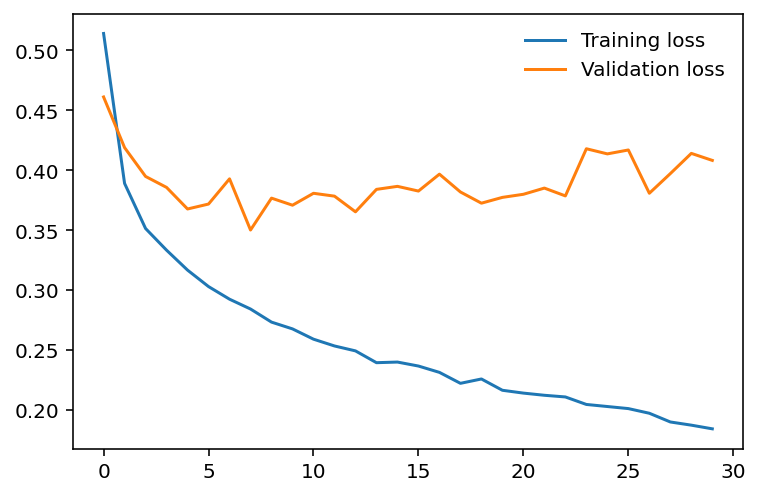

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Overfitting

If we look at the training and validation losses as we train the network, we can see a phenomenon known as overfitting.

<img src='https://github.com/udacity/deep-learning-v2-pytorch/raw/master/intro-to-pytorch/assets/overfitting.png' width=450px>

The network learns the training set better and better, resulting in lower training losses. However, it starts having problems generalizing to data outside the training set leading to the validation loss increasing. The ultimate goal of any deep learning model is to make predictions on new data, so we should strive to get the lowest validation loss possible. One option is to use the version of the model with the lowest validation loss, here the one around 8-10 training epochs. This strategy is called *early-stopping*. In practice, you would save the model frequently as you are training then later choose the model with the lowest validation loss.

The most common method to reduce overfitting (outside of early-stopping) is *dropout*, where we randomly drop input units. This forces the network to share information between weights, increasing its ability to generalize to new data. Adding dropout in PyTorch is straightforward uing the [`nn.Dropout`](https://pytorch.org/docs/stable/nn.html#torch.nn.Dropout) module.

```python
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc3 = nn.Linear(64, 10)

    # Dropout module with 0.2 drop probability
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    # Make sure input tensor is flattened
    x = x.view(x.shape[0], -1)

    # Now with dropout
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))

    # Output, so no dropout here
    x = F.log_softmax(self.fc4(x), dim=1)

    return x
```

During training we want to use dropout to prevent overfitting, but during inference we want to use the entire network. So, we need to turn off dropout during validation, testing and whenever we are using the network to make predictions. To do this, you use `model.eval()`. This set the model to evaluation mode where the dropout probability is 0. You can turn dropout back on by setting the model to train mode with `model.train()`. In general, the pattern for the validation loop will look like this, where you turn off gradients, set the model to evaluation mode, calculate the validation loss and metric, then set the model back to train mode.

```python
# turn off gradients
with torch.no_grad():

  # set model to evaluation mode
  model.eval()

  # validation pass here
  for images, labels in testloader:
    ...
  
# set model back to train mode
model.train()
```

>**Exercise:** Add dropout to your model and train it on Fashion-MNIST again. See if you can get a lower validation loss or higher accuracy.

In [27]:
## TODO: Define your model with dropout added

class ClassifierWithDropout(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(784, 256)
    self.fc2 = nn.Linear(256, 128)
    self.fc3 = nn.Linear(128, 64)
    self.fc4 = nn.Linear(64, 10)

    # Define dropout layer
    self.dropout = nn.Dropout(p=0.2)

  def forward(self, x):
    # Flatten tensor
    x = x.view(x.shape[0], -1)

    # Run through linear layers with ReLU activation
    x = self.dropout(F.relu(self.fc1(x)))
    x = self.dropout(F.relu(self.fc2(x)))
    x = self.dropout(F.relu(self.fc3(x)))

    # Run last linear layer through log_softmax
    x = F.log_softmax(self.fc4(x), dim=1)

    return x

In [30]:
# TODO: Train your model with dropout, and monitor the training progress with
# the validation loss and accuracy

model = ClassifierWithDropout()
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 30
steps = 0

train_losses, test_losses = [], []

for e in range(epochs):
  running_loss = 0.0
  for train_images, train_labels in trainloader:
    # Clear gradients
    optimizer.zero_grad()
    # Forward pass
    log_ps = model(train_images)
    # Calculate loss
    loss = criterion(log_ps, train_labels)
    # Do backpropagation and update step
    loss.backward()
    optimizer.step()
    # Add to train running_loss
    running_loss += loss.item()
  
  else:
    test_loss = 0.0
    accuracy = 0.0
    # turn off gradients
    with torch.no_grad():
      # set model to evaluation mode, turns off dropout
      model.eval()
      # validation pass here
      for test_images, test_labels in testloader:
        # Forward pass
        log_ps = model(test_images)
        # Add to test_loss
        test_loss += criterion(log_ps, test_labels)

        # Get probabilities
        ps = torch.exp(log_ps)
        # Get top class
        _, top_class = ps.topk(1, dim=1)
        # Calculate accuracy
        equals = top_class == test_labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))

    train_losses.append(running_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print(f"Epoch: {e}/{epochs}...",
          f"Training Loss: {running_loss/len(trainloader)} ...",
          f"Test Loss: {test_loss/len(testloader)} ...",
          f"Test Accuracy: {accuracy/len(testloader)}")
    
    # set model back to train mode
    model.train()

Epoch: 0/30... Training Loss: 0.6051605512687901 ... Test Loss: 0.4539129137992859 ... Test Accuracy: 0.8318073153495789
Epoch: 1/30... Training Loss: 0.47741632717949495 ... Test Loss: 0.45056283473968506 ... Test Accuracy: 0.8419585824012756
Epoch: 2/30... Training Loss: 0.45747665446132485 ... Test Loss: 0.42388856410980225 ... Test Accuracy: 0.8469347357749939
Epoch: 3/30... Training Loss: 0.42795816421318156 ... Test Loss: 0.41869649291038513 ... Test Accuracy: 0.8441480994224548
Epoch: 4/30... Training Loss: 0.42578603422590916 ... Test Loss: 0.4247734546661377 ... Test Accuracy: 0.8451433181762695
Epoch: 5/30... Training Loss: 0.4074932949216381 ... Test Loss: 0.4241624176502228 ... Test Accuracy: 0.8496218323707581
Epoch: 6/30... Training Loss: 0.40679893456796595 ... Test Loss: 0.38706713914871216 ... Test Accuracy: 0.8647491931915283
Epoch: 7/30... Training Loss: 0.39019510499449933 ... Test Loss: 0.3907123804092407 ... Test Accuracy: 0.8603702187538147
Epoch: 8/30... Trainin

## Inference

Now that the model is trained, we can use it for inference. We have done this before, but now we need to remember to set the model in inference mode with `model.eval()`. You will also want to turn off autograd with the `torch.no_grad()` context.

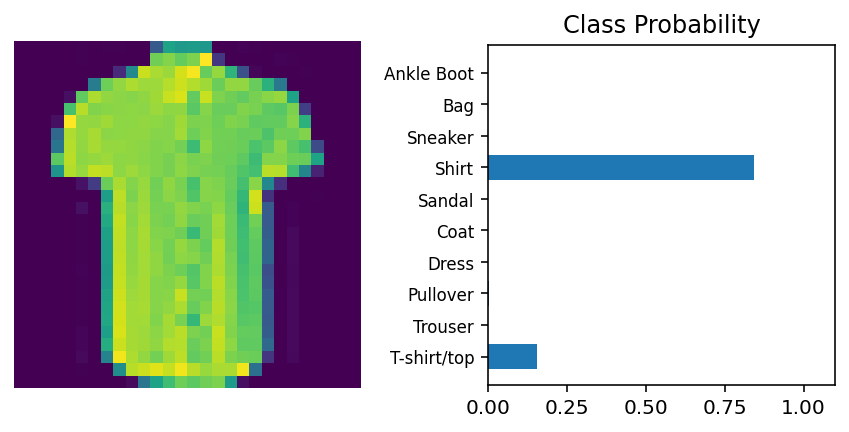

In [31]:
# Import helper module
import helper

# Test out your network!
model.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
img = images[0]
# Convert 2D image to 1D tensor
img = img.view(1, 784)

# Calculate the class probabilities (softmax) for img
with torch.no_grad():
  output = model.forward(img)

ps = torch.exp(output)

# Plot the image and probabilities
helper.view_classify(img.view(1, 28, 28), ps, version='Fashion')